In [1]:
from os import makedirs
from os.path import join, exists
from csv import DictReader
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf


def load_mnist():
    """ Load dataset from keras.datasets, reshaped and normalized
    # Returns
        :return: 2 tuples, x and y for both train and test
    """
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    x_train = (x_train.reshape(-1, 28, 28, 1).astype('float32') - 128.) / 128.
    x_test = (x_test.reshape(-1, 28, 28, 1).astype('float32') - 128.) / 255.
    y_train = tf.keras.utils.to_categorical(y_train.astype('float32'))
    y_test = tf.keras.utils.to_categorical(y_test.astype('float32'))
    return (x_train, y_train), (x_test, y_test)


def plot_log(filename, show=None):
    """ Plot log of training / validation learning curve
    # Arguments
        :param filename: str, csv log file name
        :param show: None / str, show graph if none or save to 'show' directory
    """
    # Load csv file
    keys, values, idx = [], [], None
    with open(filename, 'r') as f:
        reader = DictReader(f)
        for row in reader:
            if len(keys) == 0:
                for key, value in row.items():
                    keys.append(key)
                    values.append(float(value))
                idx = keys.index('epoch')
                continue
            for _, value in row.items():
                values.append(float(value))
        values = np.reshape(values, newshape=(-1, len(keys)))
        values[:, idx] += 1
    # Plot
    fig = plt.figure(figsize=(4, 6))
    fig.subplots_adjust(top=0.95, bottom=0.05, right=0.95)
    fig.add_subplot(211)
    for i, key in enumerate(keys):
        # training loss
        if key.find('loss') >= 0:   # and not key.find('val') >= 0:
            plt.plot(values[:, idx], values[:, i], label=key)
    plt.legend()
    plt.title('Training loss')
    fig.add_subplot(212)
    for i, key in enumerate(keys):
        # acc
        if key.find('acc') >= 0:
            plt.plot(values[:, idx], values[:, i], label=key)
    plt.legend()
    plt.title('Training and validation accuracy')
    if show is not None:
        fig.savefig(join(show, 'log.png'))
    else:
        plt.show()


def train(model, data, opt):
    """ Training a model
    # Arguments
        :param model: keras model, model
        :param data: tuple of numpy array, x and y data
        :param opt: dict, options
            tensorboard: None / str, directory for tensorboard information
            histfreq: int, histogram epoch frequency (for tensorboard)
            save_dir: str, directory for saving all results
            lr: float, learning rate
            lr_decay: float, learning rate decay
            epoch: int, epoch
            valid_pct: float, percentage of dataset used for validation
            batch_size: int, batch size
    # Returns
        :return: keras model, trained model
    """
    # Callbacks
    cb = list()
    cb.append(tf.keras.callbacks.CSVLogger(join(opt['save_dir'], 'log.csv')))
    saveweights = join(opt['save_dir'], 'weights-{epoch:02d}.h5')
    cb.append(tf.keras.callbacks.ModelCheckpoint(saveweights,
                                                 monitor='val_loss',
                                                 save_best_only=True,
                                                 save_weights_only=True,
                                                 verbose=1))
    '''
    cb.append(tf.keras.callbacks.LearningRateScheduler(
        schedule=lambda epoch: opt['lr'] * (opt['lr_decay'] ** opt['epoch']))
    )
    '''

    # Compile model
    model.compile(optimizer=tf.keras.optimizers.SGD(lr=opt['lr']),
                  loss=tf.keras.losses.MSE,
                  metrics=[tf.keras.metrics.MAE])

    # Splitting training and validation data
    (x_train, y_train) = data
    sep = int(opt['valid_pct'] * x_train.shape[0])
    perm = np.random.permutation(x_train.shape[0])
    x_valid, y_valid = x_train[perm[:sep]], y_train[perm[:sep]]
    x_train, y_train = x_train[perm[sep:]], y_train[perm[sep:]]

    # Training
    model.fit(x=[x_train], y=[y_train], validation_data=[x_valid, y_valid],
              batch_size=opt['batch_size'], epochs=opt['epoch'], callbacks=cb)

    lastweights = join(opt['save_dir'], 'lastweights.h5')
    model.save_weights(lastweights)
    print('Model weights saved to \'%s\'' % lastweights)

    # Plot learning curves
    plot_log(join(opt['save_dir'], 'log.csv'), show=None)
    return model


def test(model, data, opt):
    """ Test model on test data
    # Arguments
        :param model: keras compiled model, model
        :param data: tuple of numpy array, x and y test data
        :param opt: dict, options:
            test_batch_size: int, size of batch for test
    """
    x_test, y_test = data
    y_pred = model.predict(x_test, batch_size=opt['test_batch_size'])
    print('-' * 50)
    print('Test acc:', np.sum(np.argmax(y_pred, 1) == np.argmax(y_test, 1)) / y_test.shape[0])

# Options are all put in a dictionary
opt = dict()

In [2]:
# Directory where to save all results
opt['save_dir'] = join('MNIST results')

# Create save directory if it does not exist
if not exists(opt['save_dir']):
    makedirs(opt['save_dir'])

# Load data
(x_train, y_train), (x_test, y_test) = load_mnist()

11493376/11490434 [==============================] - 0s 0us/step


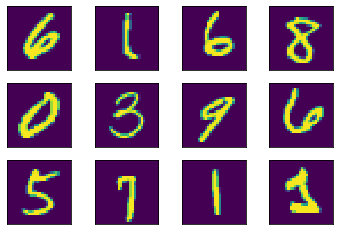

In [3]:
# Plot random image from training set
plt.figure()
rndperm, nbimgx, nbimgy = np.random.permutation(x_train.shape[0]), 4, 3
for i in range(nbimgx * nbimgy):
    plt.subplot(nbimgy, nbimgx, i + 1)
    plt.tick_params(which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
    img = (x_train[rndperm[i]] * 128. + 128.).squeeze()
    plt.imshow(img)
plt.show()

In [0]:
# Create model
lin = tf.keras.layers.Input(shape=x_train.shape[1:], name='input')
lact = lin
lact = tf.keras.layers.Conv2D(32, 3, activation='elu')(lact)
lact = tf.keras.layers.SpatialDropout2D(.2)(lact)
lact = tf.keras.layers.Conv2D(64, 3, activation='elu')(lact)
lact = tf.keras.layers.Conv2D(128, 3, activation='elu')(lact)
lact = tf.keras.layers.GlobalMaxPooling2D()(lact)
lout = tf.keras.layers.Dense(10, activation='softmax', name='output')(lact)
model = tf.keras.models.Model(lin, lout)
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 128)       73856     
_________________________________________________________________
global_max_pooling2d (Global (None, 128)               0         
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 93,962
Trainable params: 93,962


In [0]:
# Train options
opt.update({'epoch': 100, 'batch_size': 2000, 'lr': 5e-2, 'lr_decay': .99})
opt.update({'valid_pct': .2})

# File name to initialize weights to (None: random initialization)
opt['weights'] = None   # 'lastweights.h5' / None

# Init the model weights with provided one
if opt['weights'] is not None:
    model.load_weights(join(opt['save_dir'], opt['weights']))
model = train(model=model, data=(x_train, y_train), opt=opt)

In [0]:
# Test options
opt.update({'test_batch_size': 100})

test(model=model, data=(x_test, y_test), opt=opt)

--------------------------------------------------
Test acc: 0.938


In [10]:
# Create model Auto-Encoder
lin = tf.keras.layers.Input(shape=x_train.shape[1:], name='input')
lact = lin
lact = tf.keras.layers.ZeroPadding2D(1)(lact)
lact = tf.keras.layers.Conv2D(64, 3, strides=2, activation='elu')(lact)
lact = tf.keras.layers.ZeroPadding2D(1)(lact)
lact = tf.keras.layers.Conv2D(32, 3, strides=2, activation='elu')(lact)
lact = tf.keras.layers.ZeroPadding2D(1)(lact)
lact = tf.keras.layers.Conv2D(32, 3, strides=3, activation='elu')(lact)
lact = tf.keras.layers.Conv2D(16, 3, activation='elu', name='latent')(lact)
lact = tf.keras.layers.UpSampling2D(3)(lact)
lact = tf.keras.layers.ZeroPadding2D(1)(lact)
lact = tf.keras.layers.Conv2D(32, 3, activation='elu')(lact)
lact = tf.keras.layers.UpSampling2D(3)(lact)
lact = tf.keras.layers.Conv2D(32, 3, activation='elu')(lact)
lact = tf.keras.layers.UpSampling2D(2)(lact)
lact = tf.keras.layers.ZeroPadding2D(1)(lact)
lact = tf.keras.layers.Conv2D(64, 3, activation='elu')(lact)
lact = tf.keras.layers.UpSampling2D(2)(lact)
lact = tf.keras.layers.ZeroPadding2D(1)(lact)
lact = tf.keras.layers.Conv2D(1, 3, activation='elu')(lact)
lout = lact
model_ae = tf.keras.models.Model(lin, lout)
model_ae.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 28, 28, 1)]       0         
_________________________________________________________________
zero_padding2d_6 (ZeroPaddin (None, 30, 30, 1)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 64)        640       
_________________________________________________________________
zero_padding2d_7 (ZeroPaddin (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 32)          18464     
_________________________________________________________________
zero_padding2d_8 (ZeroPaddin (None, 9, 9, 32)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 3, 3, 32)          9248

Train on 48000 samples, validate on 12000 samples
Epoch 1/500
44000/48000 [==========================>...] - ETA: 0s - loss: 0.1229 - mean_absolute_error: 0.1645
Epoch 00001: val_loss improved from inf to 0.12076, saving model to MNIST results/weights-01.h5
48000/48000 [==============================] - 5s 112us/sample - loss: 0.1226 - mean_absolute_error: 0.1647 - val_loss: 0.1208 - val_mean_absolute_error: 0.1583
Epoch 2/500
44000/48000 [==========================>...] - ETA: 0s - loss: 0.1226 - mean_absolute_error: 0.1645
Epoch 00002: val_loss did not improve from 0.12076
48000/48000 [==============================] - 5s 105us/sample - loss: 0.1227 - mean_absolute_error: 0.1654 - val_loss: 0.1216 - val_mean_absolute_error: 0.1602
Epoch 3/500
44000/48000 [==========================>...] - ETA: 0s - loss: 0.1198 - mean_absolute_error: 0.1639
Epoch 00003: val_loss did not improve from 0.12076
48000/48000 [==============================] - 5s 105us/sample - loss: 0.1199 - mean_absolute_

Model weights saved to 'MNIST results/lastweights.h5'


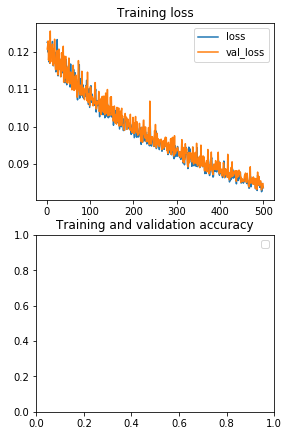

In [18]:
# Train options
opt.update({'epoch': 500, 'batch_size': 4000, 'lr': 5e-2, 'lr_decay': .99})
opt.update({'valid_pct': .2})

model_ae = train(model=model_ae, data=(x_train, x_train), opt=opt)

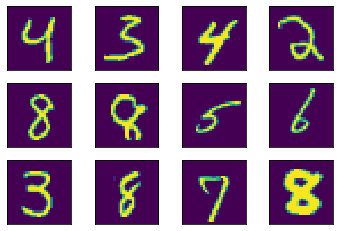

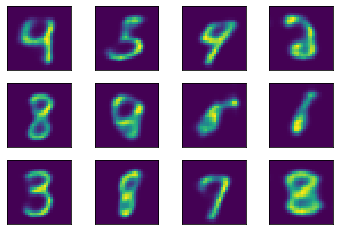

In [19]:
# Plot random image from training set
plt.figure()
rndperm, nbimgx, nbimgy = np.random.permutation(x_train.shape[0]), 4, 3
for i in range(nbimgx * nbimgy):
    plt.subplot(nbimgy, nbimgx, i + 1)
    plt.tick_params(which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
    img = (x_train[rndperm[i]] * 128. + 128.).squeeze()
    plt.imshow(img)
plt.show()
for i in range(nbimgx * nbimgy):
    plt.subplot(nbimgy, nbimgx, i + 1)
    plt.tick_params(which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
    img = model_ae.predict(np.expand_dims(x_train[rndperm[i]], 0))
    img = (img * 128. + 128.).squeeze()
    plt.imshow(img)
plt.show()